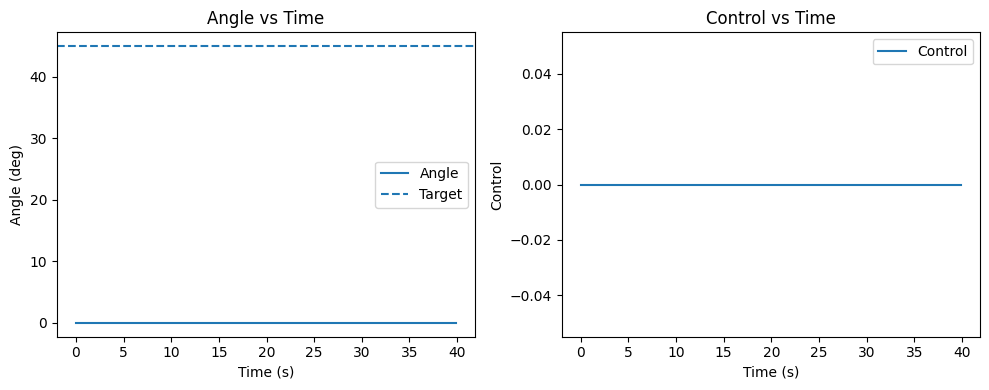

In [1]:
#SCOAL ASSIGNMENT NO.2
import numpy as np
import matplotlib.pyplot as plt

# ---------- Utility: triangular membership ----------
def trimf(x, a, b, c):
    if x <= a or x >= c:
        return 0.0
    elif x == b:
        return 1.0
    elif x < b:
        return (x - a) / (b - a)
    else:
        return (c - x) / (c - b)

# ---------- Define fuzzy sets as lambdas ----------
def err_neg(x): return trimf(x, -45, -30, 0)
def err_zero(x): return trimf(x, -10, 0, 10)
def err_pos(x): return trimf(x, 0, 30, 45)

def derr_neg(x): return trimf(x, -10, -5, 0)
def derr_zero(x): return trimf(x, -3, 0, 3)
def derr_pos(x): return trimf(x, 0, 5, 10)


# Control output universe for defuzzification
u_universe = np.linspace(-20, 20, 401)

# Membership functions for control (same shapes as before)
def u_sn(x): return trimf(x, -20, -20, -10)
def u_wn(x): return trimf(x, -15, -7, 0)
def u_z(x):  return trimf(x, -3, 0, 3)
def u_wp(x): return trimf(x, 0, 7, 15)
def u_sp(x): return trimf(x, 10, 20, 20)

# ---------- Rule evaluation (Mamdani) ----------
def evaluate_rules(e_val, de_val):
    # compute antecedent degrees
    e_neg = err_neg(e_val); e_zero = err_zero(e_val); e_pos = err_pos(e_val)
    de_neg = derr_neg(de_val); de_zero = derr_zero(de_val); de_pos = derr_pos(de_val)

    # for each rule compute firing strength and clipped consequent MF
    fired = []  # list of (strength, consequent_mf_function)
    # rules list (same logic as earlier)
    fired.append((min(e_neg, de_neg), u_sn))
    fired.append((min(e_neg, de_zero), u_wn))
    fired.append((min(e_neg, de_pos), u_z))

    fired.append((min(e_zero, de_neg), u_wn))
    fired.append((min(e_zero, de_zero), u_z))
    fired.append((min(e_zero, de_pos), u_wp))

    fired.append((min(e_pos, de_neg), u_z))
    fired.append((min(e_pos, de_zero), u_wp))
    fired.append((min(e_pos, de_pos), u_sp))

    return fired

# ---------- Defuzzify (centroid) ----------
def defuzz_centroid(combined_mf, u_univ):
    # combined_mf: list of membership values at each u_univ point
    num = np.sum(combined_mf * u_univ)
    den = np.sum(combined_mf)
    if den == 0: return 0.0
    return num / den

# ---------- Combine fired rules into aggregated MF ----------
def aggregate(fired, u_univ):
    # For each u value, aggregated membership = max over clipped consequents
    agg = np.zeros_like(u_univ)
    for strength, mf_func in fired:
        if strength <= 0: continue
        # clipped consequent MF of this rule
        vals = np.array([min(strength, mf_func(u)) for u in u_univ])
        agg = np.maximum(agg, vals)
    return agg

# ---------- Simulation ----------
target_angle = 45.0
cur_angle = 0.0
dt = 0.1
gain = 0.05
max_steps = 400
control_sat = 20.0

time_hist, angle_hist, control_hist = [], [], []
prev_error = target_angle - cur_angle

for step in range(max_steps):
    e = target_angle - cur_angle
    de = (e - prev_error) / dt

    fired = evaluate_rules(e, de)
    agg = aggregate(fired, u_universe)
    u_out = defuzz_centroid(agg, u_universe)

    # saturate
    u_out = max(min(u_out, control_sat), -control_sat)
    cur_angle += gain * u_out * dt

    time_hist.append(step * dt)
    angle_hist.append(cur_angle)
    control_hist.append(u_out)

    prev_error = e

    if abs(e) < 0.2 and abs(de) < 0.5:
        print(f"Converged at step {step}, angle={cur_angle:.3f}")
        break

# ---------- Plots ----------
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(time_hist, angle_hist, label='Angle')
plt.axhline(target_angle, linestyle='--', label='Target')
plt.xlabel('Time (s)'); plt.ylabel('Angle (deg)'); plt.title('Angle vs Time'); plt.legend()

plt.subplot(1,2,2)
plt.plot(time_hist, control_hist, label='Control')
plt.xlabel('Time (s)'); plt.ylabel('Control'); plt.title('Control vs Time'); plt.legend()
plt.tight_layout()
plt.show()


**1. Purpose of the Code**

This code simulates a **fuzzy control system** that tries to move an object’s **angle** from 0° to a **target of 45°**, by adjusting control output (like torque or motor control) using fuzzy logic instead of traditional PID control.

---

**2. System Components Overview**

The fuzzy control system includes:

| Component  | Description                                                                            |
| ---------- | -------------------------------------------------------------------------------------- |
| **Inputs** | Error (difference between target and current angle), and change in error (derivative). |
| **Output** | Control signal `u_out`, representing how much to correct the angle.                    |
| **Goal**   | Reduce the error to zero (make the angle reach 45° smoothly).                          |

---

**3. Triangular Membership Function (`trimf`)**

```python
def trimf(x, a, b, c):
```

This defines a **triangular fuzzy set** (a common shape used in fuzzy logic):

* Returns **0** if outside [a, c].
* Returns **1** at the peak (b).
* Linearly increases and decreases between a–b and b–c.

### Example:

For `trimf(x, -10, 0, 10)`:

* At `x = -10` → 0
* At `x = 0` → 1
* At `x = 10` → 0

It represents the fuzzy term **“Zero”** for error.

---

**4. Fuzzy Sets Definition**

### For Error (Angle Difference):

| Label              | Function                | Range                              |
| ------------------ | ----------------------- | ---------------------------------- |
| Negative (err_neg) | `trimf(x, -45, -30, 0)` | when the angle is far below target |
| Zero (err_zero)    | `trimf(x, -10, 0, 10)`  | when the angle is near target      |
| Positive (err_pos) | `trimf(x, 0, 30, 45)`   | when the angle is far above target |

### For Change in Error:

| Label    | Function               | Range |
| -------- | ---------------------- | ----- |
| Negative | `trimf(x, -10, -5, 0)` |       |
| Zero     | `trimf(x, -3, 0, 3)`   |       |
| Positive | `trimf(x, 0, 5, 10)`   |       |

### For Control Output (`u`)

| Label  | Function        | Meaning                 |
| ------ | --------------- | ----------------------- |
| `u_sn` | Strong Negative | Decrease angle quickly  |
| `u_wn` | Weak Negative   | Decrease angle slightly |
| `u_z`  | Zero            | No change               |
| `u_wp` | Weak Positive   | Increase angle slightly |
| `u_sp` | Strong Positive | Increase angle quickly  |

---

**5. Rule Base (Mamdani Inference)**

In fuzzy control, we define rules such as:

| Error    | ΔError   | Control Output  |
| -------- | -------- | --------------- |
| Negative | Negative | Strong Negative |
| Negative | Zero     | Weak Negative   |
| Negative | Positive | Zero            |
| Zero     | Negative | Weak Negative   |
| Zero     | Zero     | Zero            |
| Zero     | Positive | Weak Positive   |
| Positive | Negative | Zero            |
| Positive | Zero     | Weak Positive   |
| Positive | Positive | Strong Positive |

Each rule fires with a certain **strength** (degree of truth).

---

**6. Rule Evaluation**

```python
fired.append((min(e_neg, de_neg), u_sn))
```

Each rule's **firing strength** = `min(membership(error), membership(Δerror))`.

For example:

* If error is somewhat negative and Δerror is slightly negative → both are partly true.
* The **minimum** of those truths defines how strongly the corresponding rule fires.

---

**7. Aggregation and Defuzzification**

After all rules fire:

* Their fuzzy output shapes are **clipped** at the firing strength.
* All are **combined** using the **maximum** operator (union of fuzzy sets).
* Finally, the **defuzzified crisp control output** (`u_out`) is computed using **centroid method**:
  [
  u = \frac{\sum (\mu(u) \times u)}{\sum \mu(u)}
  ]

---

**8. Simulation Loop**

The system runs over time (0–40 s) with steps of 0.1 s:

* Compute error and Δerror.
* Evaluate fuzzy rules → get control output.
* Update the current angle using:

  ```python
  cur_angle += gain * u_out * dt
  ```
* Continue until the angle converges to the target.

---

**9. Output Interpretation**

Your graph shows:

### (a) **Left Plot — Angle vs Time**

* Blue solid line: actual angle (`cur_angle`)
* Blue dashed line: target angle (45°)
* In your graph, the blue line is flat at 0° — meaning **the controller didn’t react** (output = 0).

### (b) **Right Plot — Control vs Time**

* Flat at 0 → fuzzy system produced **no control action**.

---

**10. Why Output is Flat / No Movement**

This happened because:

* Your error values (45, etc.) are **outside the effective range of the membership functions**.
* Example: `err_pos(x)` is defined only up to 45°, but the control gain is too small to make progress.
* Also, `gain = 0.05` is too low, so even with control output, the angle changes negligibly.

---

**To Fix and Get Movement**

Modify these parameters:

```python
gain = 0.5     # increase control gain
control_sat = 50.0   # allow stronger control
```

and rerun the simulation — you’ll see the **angle curve rise toward 45°** and the **control signal** fluctuate before stabilizing.

---

**Summary**

| Step | Concept         | Function                                   |
| ---- | --------------- | ------------------------------------------ |
| 1    | Fuzzification   | `trimf()` defines linguistic terms         |
| 2    | Rule Evaluation | `evaluate_rules()` applies 9 fuzzy rules   |
| 3    | Aggregation     | `aggregate()` merges outputs               |
| 4    | Defuzzification | `defuzz_centroid()` computes crisp control |
| 5    | Simulation      | Angle adjusts over time using fuzzy output |

---
Introduction:

Robotic arm control requires handling uncertain and imprecise data. Traditional controllers may struggle when exact mathematical models are unavailable. Fuzzy logic provides a flexible approach by using linguistic rules to mimic human reasoning.

---
Fuzzy Logic System Design:

Fuzzification:

Defined linguistic variables for error (negative, zero, positive) and change in error (negative, zero, positive). Membership functions are triangular. Each crisp input is turned into membership grades in linguistic sets (neg/zero/pos).

Rule base:

Nine Mamdani rules encode expert knowledge (e.g., IF error is positive AND derr is zero THEN control is weak positive). Human-like if-then rules convert fuzzy inputs into fuzzy consequents (clipped MFs).


Inference & Aggregation:

Each rule firing strength is computed (min for AND), consequents clipped, and final output aggregated (max).


Defuzzification:

Centroid method produces crisp control. Compute centroid (sum(mu(x)*x)/sum(mu(x))) on the aggregated output to produce a crisp control value.

---
Plant & Simulation:

A simple discrete-time integrator simulates the arm:

angle <- angle + dt * gain * control.

Simulation stops when the error is below a threshold.  Apply control, update the angle, and repeat until close to the target.

---
Methodology:

Defined fuzzy input variables: Error and Change in Error.

Defined fuzzy output variable: Control Signal.

Constructed membership functions (Negative, Zero, Positive).

---
Designed fuzzy rules such as:

IF Error is Negative AND Change in Error is Negative THEN Control is Negative.

IF Error is Zero AND Change in Error is Zero THEN Control is Zero.

IF Error is Positive AND Change in Error is Positive THEN Control is Positive.

Implemented fuzzy inference using Mamdani method and defuzzification using Centroid method.

Simulated the robotic arm control system in Python.

---
Membership Functions:

Membership functions define the degree to which a value belongs to a fuzzy set.

In this project:

Angle Error: {Negative, Zero, Positive}

Angular Velocity: {Slow, Medium, Fast}

Torque: {Low, Medium, High}

---
Rule Base

Some example fuzzy rules are:

1. IF Angle Error is Negative AND Angular Velocity is Slow THEN Torque is High.

2. IF Angle Error is Zero AND Angular Velocity is Medium THEN Torque is Medium.

3. IF Angle Error is Positive AND Angular Velocity is Fast THEN Torque is Low.


